In [5]:
import pandas as pd
import numpy as np

from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from scipy.sparse import hstack
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import average_precision_score , roc_auc_score

In [6]:
df = pd.read_csv('raw_data_wlabels.csv').drop('Unnamed: 0',axis=1).dropna()
(df['y']==1).sum()

340

In [7]:
df = pd.read_csv('raw_data_wlabels.csv').drop('Unnamed: 0',axis=1).dropna()

y = df['y']
xdata = df.drop('y',axis=1)

data_train,data_val,ytrain,yval = train_test_split(xdata,
                                                    y,
                                                    test_size = 0.5,
                                                    random_state=0)

In [8]:
# Vetorizando os titulos
title_train = data_train['titles']
title_val = data_val['titles']

title_vec = TfidfVectorizer(min_df = 2,ngram_range=(1,1))

title_bow_train = title_vec.fit_transform(title_train)
title_bow_val = title_vec.transform(title_val)

autor_train = data_train['author']
autor_val = data_val['author']

autor_vec = TfidfVectorizer(min_df = 2,ngram_range=(1,2))

autor_bow_train = autor_vec.fit_transform(autor_train)
autor_bow_val = autor_vec.transform(autor_val)

In [9]:
mask_train = data_train.drop(['titles','author'],axis=1)
mask_val = data_val.drop(['titles','author'],axis=1)

xtrain_wvec = hstack([title_bow_train,autor_bow_train,mask_train])
xval_wvec = hstack([title_bow_val,autor_bow_val,mask_val])

# LGBM

C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


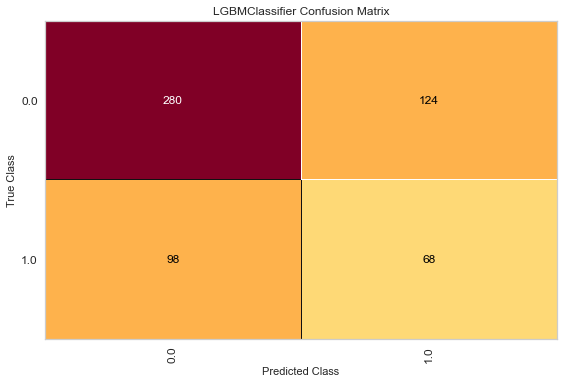

<AxesSubplot:title={'center':'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [10]:
lgbm = ConfusionMatrix(LGBMClassifier(random_state = 0,class_weight ='balanced',n_jobs=6))
lgbm = lgbm.fit(xtrain_wvec,ytrain)
lgbm.score(xval_wvec, yval)
lgbm.poof()

In [11]:
p = lgbm.predict_proba(xval_wvec)[:,1]
print(f'{(yval==0).sum()} "0" e {(yval==1).sum()} "1" ')

404 "0" e 166 "1" 


In [12]:
k = 279   #0/0
j = 64   #1/1

print(f'0/0 : {(k/((yval==0).sum()) )*100}%')
print(f'1/1 : {(j/((yval==1).sum()))*100}%')

0/0 : 69.05940594059405%
1/1 : 38.55421686746988%


In [13]:
print(f'AVG : {average_precision_score(yval,p)} \nROC : {roc_auc_score(yval,p)}')

AVG : 0.3434728669544407 
ROC : 0.5557303471310986


# Bayseian Optmization

In [14]:
from skopt import forest_minimize

In [15]:
def tune_lgbm(params):
    print(params)
    lr = params[0]
    max_depth = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    n_estimators = params[5]
    min_df = params[6]
    ngram_range = (1,params[7])
    
    title_vec = TfidfVectorizer(min_df = min_df,ngram_range=ngram_range)
    title_bow_train = title_vec.fit_transform(title_train)
    title_bow_val = title_vec.transform(title_val)
    
    autor_vec = TfidfVectorizer(min_df = min_df,ngram_range=ngram_range)
    autor_bow_train = title_vec.fit_transform(autor_train)
    autor_bow_val = title_vec.transform(autor_val)
    
    
    xtrain_wvec = hstack([title_bow_train,autor_bow_train,mask_train])
    xval_wvec = hstack([title_bow_val,autor_bow_val,mask_val])
    
    mdl = LGBMClassifier(learning_rate=lr, num_leaves= 2**max_depth, max_depth=max_depth,
                         min_child_samples=min_child_samples, subsample=subsample,
                         colsample_bytree=colsample_bytree, bagging_freq = 1, n_estimators=n_estimators, 
                         random_state = 0, class_weight ='balanced',n_jobs=6)
    mdl.fit(xtrain_wvec,ytrain)
    
    p = mdl.predict_proba(xval_wvec)[:,1]
    
    print(roc_auc_score(yval,p))
    
    return -average_precision_score(yval,p)

In [16]:
space = [(1e-3,1e-1,'log-uniform'), #lr
         (1,10),    # max_depth
         (1,10),    #min_child_samples
         (0.05,1.), #subsamples
         (0.05,1.), #colsample_bytree
         (100,1000),#n_estimators
         (1,5),     #min_df
         (1,5)      #ngram_range 
        ] 

In [17]:
res = forest_minimize(tune_lgbm,space,random_state=160745,n_random_starts=20,n_calls=50,verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272, 3, 1]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6546731480376953
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.4899
Function value obtained: -0.4690
Current minimum: -0.4690
Iteration No: 2 started. Evaluating function at random point.
[0.053887464791860025, 1, 6, 0.20280403175305034, 0.5270541127738826, 450, 4, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6047208636526303
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2220
Function value obtained: -0.4064
Current minimum: -0.4690
Iteration No: 3 started. Evaluating function at random point.
[0.052788841014904574, 9, 8, 0.8057204751674488, 0.12087803699306042, 348, 1, 2]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.613988130740785
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3370
Function value obtained: -0.3982
Current minimum: -0.4690
Iteration No: 4 started. Evaluating function at random point.
[0.002581171760283021, 2, 10, 0.6501625354578521, 0.10208277342628153, 491, 3, 5]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.5801845997852797
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1940
Function value obtained: -0.4077
Current minimum: -0.4690
Iteration No: 5 started. Evaluating function at random point.
[0.004758611359340044, 6, 1, 0.31239887914485304, 0.078212872072331, 414, 2, 5]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6632172253369915
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.9570
Function value obtained: -0.4854
Current minimum: -0.4854
Iteration No: 6 started. Evaluating function at random point.
[0.007990318740531337, 10, 5, 0.22076129610800188, 0.8242914803205513, 760, 3, 2]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6087692353572707
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.9830
Function value obtained: -0.4033
Current minimum: -0.4854
Iteration No: 7 started. Evaluating function at random point.
[0.06867197721040089, 7, 7, 0.811247998237159, 0.6963955932783014, 683, 3, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.5792079207920793
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.6040
Function value obtained: -0.3566
Current minimum: -0.4854
Iteration No: 8 started. Evaluating function at random point.
[0.006698746827135841, 3, 10, 0.21661986152103802, 0.5158440564749048, 697, 1, 2]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.5508693188595968
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.3340
Function value obtained: -0.3794
Current minimum: -0.4854
Iteration No: 9 started. Evaluating function at random point.
[0.009930612420765688, 9, 7, 0.944578432980404, 0.6756555673858103, 601, 3, 3]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6207354169151854
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.5785
Function value obtained: -0.4226
Current minimum: -0.4854
Iteration No: 10 started. Evaluating function at random point.
[0.0013481754050030364, 2, 1, 0.6323096758146287, 0.5750267866863973, 213, 5, 3]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.6083442681617559
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.1410
Function value obtained: -0.4276
Current minimum: -0.4854
Iteration No: 11 started. Evaluating function at random point.
[0.00659463294657322, 9, 4, 0.6163520855275999, 0.3478164905580535, 172, 5, 2]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6415737206250747
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.2510
Function value obtained: -0.4517
Current minimum: -0.4854
Iteration No: 12 started. Evaluating function at random point.
[0.05173196942311445, 5, 8, 0.5409573219011281, 0.47699927439410444, 424, 3, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.5917854586663486
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.3010
Function value obtained: -0.3810
Current minimum: -0.4854
Iteration No: 13 started. Evaluating function at random point.
[0.024268297340996742, 8, 4, 0.27293941891193163, 0.08212463889621416, 274, 2, 1]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6296970058451629
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 0.2220
Function value obtained: -0.4162
Current minimum: -0.4854
Iteration No: 14 started. Evaluating function at random point.
[0.005545743892663144, 6, 8, 0.15621607594420134, 0.3235590455448425, 259, 4, 5]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.5600843969939163
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 0.1950
Function value obtained: -0.3624
Current minimum: -0.4854
Iteration No: 15 started. Evaluating function at random point.
[0.00977659787376616, 7, 1, 0.32861324392209, 0.6502675785918055, 967, 3, 2]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.642624955266611
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 1.7250
Function value obtained: -0.4488
Current minimum: -0.4854
Iteration No: 16 started. Evaluating function at random point.
[0.0015500670574312128, 2, 8, 0.675985625740636, 0.1702980548721404, 158, 1, 3]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.5818173684838364
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 0.1910
Function value obtained: -0.3969
Current minimum: -0.4854
Iteration No: 17 started. Evaluating function at random point.
[0.06974785519438091, 9, 6, 0.8694055797102738, 0.5176070955424907, 695, 3, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.587722175832041
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 1.0710
Function value obtained: -0.3637
Current minimum: -0.4854
Iteration No: 18 started. Evaluating function at random point.
[0.00782259176202122, 2, 10, 0.8744623478499286, 0.8022374103184922, 612, 1, 5]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.5872151974233568
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 0.2660
Function value obtained: -0.3794
Current minimum: -0.4854
Iteration No: 19 started. Evaluating function at random point.
[0.0024919296041103494, 6, 8, 0.9946871410890346, 0.233506774227642, 370, 5, 1]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6275050697840869
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 0.2420
Function value obtained: -0.4462
Current minimum: -0.4854
Iteration No: 20 started. Evaluating function at random point.
[0.004955402904180171, 6, 1, 0.13021457554920057, 0.6158804906347372, 615, 3, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6489472742454968
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 1.3980
Function value obtained: -0.4511
Current minimum: -0.4854
Iteration No: 21 started. Searching for the next optimal point.
[0.0027588181372899044, 6, 2, 0.5389103665128818, 0.26060765375211153, 795, 4, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6778301324108313
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 1.2855
Function value obtained: -0.5029
Current minimum: -0.5029
Iteration No: 22 started. Searching for the next optimal point.
[0.027928151964700804, 2, 2, 0.9006435596570321, 0.20331170392694486, 899, 4, 5]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6915856495288084
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.6890
Function value obtained: -0.5250
Current minimum: -0.5250
Iteration No: 23 started. Searching for the next optimal point.
[0.07881540887744758, 3, 2, 0.5713118916536011, 0.20722928685017578, 907, 1, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6592583204103543
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 1.0350
Function value obtained: -0.4566
Current minimum: -0.5250
Iteration No: 24 started. Searching for the next optimal point.
[0.05151553156603058, 9, 2, 0.3506126851355745, 0.24395535433829652, 817, 1, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.641968865561255
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 2.1490
Function value obtained: -0.4400
Current minimum: -0.5250
Iteration No: 25 started. Searching for the next optimal point.
[0.054057617355222805, 3, 3, 0.6192406361094862, 0.16887916144420234, 967, 4, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6718507694142908
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.7380
Function value obtained: -0.4888
Current minimum: -0.5250
Iteration No: 26 started. Searching for the next optimal point.
[0.023939148992552034, 5, 3, 0.566158808612134, 0.2906354506276169, 949, 4, 5]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6674370750328045
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.9800
Function value obtained: -0.4855
Current minimum: -0.5250
Iteration No: 27 started. Searching for the next optimal point.
[0.0013822164367389843, 2, 4, 0.5029891073819075, 0.2362701931331762, 833, 4, 5]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6424534772754383
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.6600
Function value obtained: -0.4603
Current minimum: -0.5250
Iteration No: 28 started. Searching for the next optimal point.
[0.022205546182536597, 2, 3, 0.4174872691743113, 0.09811340806608981, 197, 4, 5]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.6526079565787903


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4950
Function value obtained: -0.4608
Current minimum: -0.5250
Iteration No: 29 started. Searching for the next optimal point.
[0.0014732257146294141, 1, 3, 0.9619028069197244, 0.49786125209724885, 985, 4, 5]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6213244065370391
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.6620
Function value obtained: -0.4214
Current minimum: -0.5250
Iteration No: 30 started. Searching for the next optimal point.
[0.03310883520216798, 2, 2, 0.6921239515300378, 0.16395004371182015, 740, 5, 5]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6505353095550519
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.6010
Function value obtained: -0.4515
Current minimum: -0.5250
Iteration No: 31 started. Searching for the next optimal point.
[0.0017606961005459585, 10, 2, 0.7976031342753723, 0.23056440691282926, 906, 4, 5]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6951121316950972
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 1.8870
Function value obtained: -0.5297
Current minimum: -0.5297
Iteration No: 32 started. Searching for the next optimal point.
[0.005261611458710857, 5, 2, 0.8319160591010824, 0.3591200240141973, 999, 4, 5]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6837051174997018
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 1.1700
Function value obtained: -0.5171
Current minimum: -0.5297
Iteration No: 33 started. Searching for the next optimal point.
[0.0028449988339630927, 9, 2, 0.9181584734559524, 0.9762479422651797, 890, 4, 5]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6706131456519145
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.7537
Function value obtained: -0.4888
Current minimum: -0.5297
Iteration No: 34 started. Searching for the next optimal point.
[0.015843247390718167, 10, 2, 0.8501489616502615, 0.17217549304023022, 879, 4, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6994960038172492
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 1.6635
Function value obtained: -0.5273
Current minimum: -0.5297
Iteration No: 35 started. Searching for the next optimal point.
[0.02427462374080208, 9, 2, 0.8206277654056401, 0.6131824191523177, 950, 4, 5]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6692562328522008
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 1.7339
Function value obtained: -0.4769
Current minimum: -0.5297
Iteration No: 36 started. Searching for the next optimal point.
[0.00296483494867953, 5, 2, 0.9948778494455206, 0.23047481026128364, 978, 4, 3]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6784191220326852
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 1.1392
Function value obtained: -0.5090
Current minimum: -0.5297
Iteration No: 37 started. Searching for the next optimal point.
[0.011752683005960626, 6, 2, 0.9603313637169426, 0.24696367975579864, 907, 5, 1]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6601157103662174
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 0.9900
Function value obtained: -0.4534
Current minimum: -0.5297
Iteration No: 38 started. Searching for the next optimal point.
[0.0023629031512393595, 2, 2, 0.8637318332285895, 0.15266883099044037, 865, 4, 5]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6607718000715734
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 0.6780
Function value obtained: -0.4844
Current minimum: -0.5297
Iteration No: 39 started. Searching for the next optimal point.
[0.0020106602453669286, 8, 2, 0.9969721646471306, 0.1509947299037583, 652, 4, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6824898604318262
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 1.1650
Function value obtained: -0.5101
Current minimum: -0.5297
Iteration No: 40 started. Searching for the next optimal point.
[0.006474110088919687, 8, 5, 0.7832718196264455, 0.2786334711379838, 955, 4, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6613160563044257
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 1.1040
Function value obtained: -0.4676
Current minimum: -0.5297
Iteration No: 41 started. Searching for the next optimal point.
[0.06262226233533313, 10, 2, 0.9949120520728693, 0.21198321186254715, 532, 4, 5]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6873136108791603
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.1950
Function value obtained: -0.4976
Current minimum: -0.5297
Iteration No: 42 started. Searching for the next optimal point.
[0.02207860947758099, 10, 2, 0.88890893356089, 0.2541982325520642, 613, 4, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6915781939639747
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 1.3570
Function value obtained: -0.5261
Current minimum: -0.5297
Iteration No: 43 started. Searching for the next optimal point.
[0.008273523782211271, 10, 2, 0.9664465525959738, 0.2350882092252728, 889, 3, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6890507574853871
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 2.0300
Function value obtained: -0.5087
Current minimum: -0.5297
Iteration No: 44 started. Searching for the next optimal point.
[0.01648228728265271, 10, 2, 0.843808346754445, 0.19012097275423878, 854, 1, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6715898246451151
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 2.2860
Function value obtained: -0.4901
Current minimum: -0.5297
Iteration No: 45 started. Searching for the next optimal point.
[0.06712306784509056, 10, 2, 0.9414877247247568, 0.24452366735329462, 450, 3, 3]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6879175116306813
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.1750
Function value obtained: -0.4903
Current minimum: -0.5297
Iteration No: 46 started. Searching for the next optimal point.
[0.06211190286304743, 10, 3, 0.8748377973836894, 0.28246007109001164, 993, 2, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6430872002862937
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 2.2760
Function value obtained: -0.4365
Current minimum: -0.5297
Iteration No: 47 started. Searching for the next optimal point.
[0.001824808925633433, 10, 2, 0.644949642105115, 0.3215095949661906, 502, 4, 2]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6917869497793153
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 1.2160
Function value obtained: -0.5160
Current minimum: -0.5297
Iteration No: 48 started. Searching for the next optimal point.
[0.0078109534346673636, 10, 2, 0.7767694359667894, 0.3657377142034356, 281, 4, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6835858284623644
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 0.9660
Function value obtained: -0.5184
Current minimum: -0.5297
Iteration No: 49 started. Searching for the next optimal point.
[0.0014789710262601851, 10, 2, 0.07990166589545716, 0.1524242578463617, 284, 4, 2]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6140999642132887
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 0.6450
Function value obtained: -0.4516
Current minimum: -0.5297
Iteration No: 50 started. Searching for the next optimal point.
[0.007984816606870932, 10, 2, 0.7333750492226216, 0.6186658494084182, 251, 4, 4]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


0.6746093284027197
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 0.9270
Function value obtained: -0.5021
Current minimum: -0.5297


In [18]:
best = res.x
best

[0.0017606961005459585,
 10,
 2,
 0.7976031342753723,
 0.23056440691282926,
 906,
 4,
 5]

# LGBM Optimized

In [19]:
title_vec = TfidfVectorizer(min_df = best[6] ,ngram_range = (1,best[7]))
title_bow_train = title_vec.fit_transform(title_train)
title_bow_val = title_vec.transform(title_val)

autor_vec = TfidfVectorizer(min_df = best[6] ,ngram_range = (1,best[7]))
autor_bow_train = autor_vec.fit_transform(autor_train)
autor_bow_val = autor_vec.transform(autor_val)
    
    
xtrain_wvec = hstack([title_bow_train,autor_bow_train,mask_train])
xval_wvec = hstack([title_bow_val,autor_bow_val,mask_val])

In [20]:
LGBM =  ConfusionMatrix(LGBMClassifier(learning_rate=best[0], num_leaves= 2 ** best[1], max_depth=best[1],
                         min_child_samples=best[2], subsample=best[3],
                         colsample_bytree=best[4], bagging_freq = 1, n_estimators=best[5], 
                         random_state = 0, class_weight ='balanced',n_jobs=6))

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\Guilherme Miranda\anaconda3\lib\site-packages\lightgbm\basic.py:739: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


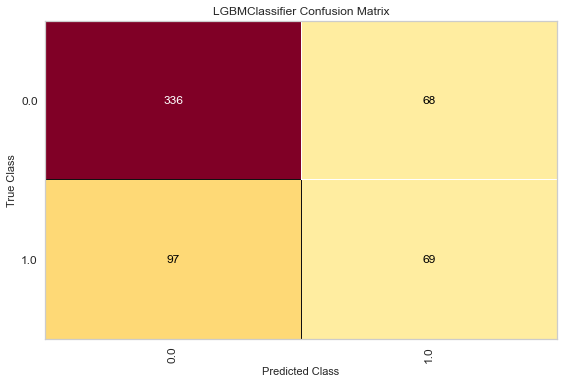

<AxesSubplot:title={'center':'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [21]:
LGBM = LGBM.fit(xtrain_wvec,ytrain)
LGBM.score(xval_wvec, yval)
LGBM.poof()

In [22]:
p = LGBM.predict_proba(xval_wvec)[:,1]

In [23]:
k = 336   #0/0
j = 69   #1/1

print(f'0/0 : {(k/((yval==0).sum()) )*100}%')
print(f'1/1 : {(j/((yval==1).sum()))*100}%')

0/0 : 83.16831683168317%
1/1 : 41.566265060240966%


In [25]:
print(f'LGBM Metrics \nAVG : {average_precision_score(yval,p)} \nROC : {roc_auc_score(yval,p)}')

LGBM Metrics 
AVG : 0.5296939830564515 
ROC : 0.6951121316950972
